<a href="https://colab.research.google.com/github/nicsim22/DS110-Content/blob/main/Lecture26ModernNLPandML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modern Natural Language Processing With Machine Learning

*Cynthia had a strong hypothesis, that cash was causing the spread of BND, but being able to identify whole countries at risk just wasn't good enough.  Cynthia wanted to be able to trace the spread of the disease through individuals.*

*Through SAGE, Cynthia had access to a huge collection of Facebook and Instagram posts, among other things.  She might be able to figure out who was making cash purchases from those.  But how was she going to identify who was posting about buying and selling stuff?  She started to list words associated with commerce - "buy", "market," "purchase" - there were just too many.  She was not going to write that regular expression from hell.*

*...Of course!  She'd heard that you could turn words into vectors - "embeddings" - and then apply machine learning to that.  She just had to look up how to use these "embeddings."*

Today we'll explore modern natural language processing (NLP).  The key problem we'll solve is, if you have textual data, how can you use it effectively as another signal in machine learning?  The key idea is to transform the words into numbers somehow.  In general, such a transformation is called an *embedding*.

There are a variety of tasks you might want to perform with language and ML.  One example is **sentiment analysis**, or classifying whether a snippet of text like a product review is happy or unhappy with what it's talking about.

In [ ]:
# Load a dataset used for sentiment analysis, SST2
# Column 0 is a movie review, column 1 is sentiment (0 for negative, 1 for positive)

import pandas as pd

SST2_LOC = 'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv' #can just do it this way with URL
df = pd.read_csv(SST2_LOC, delimiter='\t', header=None)

In [ ]:
df

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
6915,"painful , horrifying and oppressively tragic ,...",1
6916,take care is nicely performed by a quintet of ...,0
6917,"the script covers huge , heavy topics in a bla...",0
6918,a seriously bad film with seriously warped log...,0


A basic way we could build features out of text is to turn the text into a vector of boolean values: 1 if a particular word is present, and 0 if not.  We can then easily imagine decision tree rules like "if the sentence contains the word 'fabulous,' classify as positive sentiment."

This representation is sometimes called "bag of words" because the resulting vector has forgotten information like word order; it's as if we put all the words in a bag and they got jostled around.  (This already means that some sentences, like "I don't *not* like it," will be totally beyond our classifier's abilities.)

Extracting words from a sentence sounds easy, but simple rules to do it may not work.  For example, you might think you should split at a comma ",", but if that comma is in the middle of a number, you should treat the whole number as one *token* (a word, piece of punctuation, or other meaningful snippet).  You should break up text with a **tokenizer**, like the Punkt tokenizer that comes with the NLTK module, rather than trying to craft your own tokenization rules.  This particular tokenizer works using some trained machine learning, and it needs you to download its data to work correctly.

In [ ]:
# Let's see an example of tokenization --> takes a sentence and break it down into words
import nltk

from nltk.tokenize import word_tokenize
nltk.download('punkt') # Name means 'period' in German; from Kiss and Strunk 2006
word_tokenize("Biden won't sell the White House for even $1,000,000,000.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['Biden',
 'wo',
 "n't",
 'sell',
 'the',
 'White',
 'House',
 'for',
 'even',
 '$',
 '1,000,000,000',
 '.']

We can create new columns for our dataframe that contain word features.  In a first pass, we tokenize everything and create a word set for each line, as well as a set for all the text together.  In a second pass, we iterate through the words of the vocabulary and create one column per word, putting 1's for rows where the string contained the word and 0 elsewhere.

In [ ]:
# Setting up one-hot encoding, for contrast with embedding performance
# later.  Note that this cell takes a while!

def wordset(raw_text):
  tokenized = word_tokenize(raw_text.lower())
  return set(tokenized)

# Returns first the set of all words in the column, and second,
# a dictionary from text to tokenized word sets.  This will let
# us not need to call the tokenizer so much, if we remember its
# results for each line.
def all_words_set(df_column):
  set_of_all = set()
  dict_of_all = {}
  for row in df_column:
    textset = wordset(row)
    set_of_all = set_of_all.union(textset)
    dict_of_all[row] = textset
  return set_of_all, dict_of_all

# Create the dataframe of one-hot encodings:  each column is a word,
# 0 or 1 for a row if that example had that word
def one_hot_columns(df_column):
  all_words, all_tokenizations = all_words_set(df_column)
  word_dict = {}
  for word in all_words:
    word_present_list = []
    for line_num in range(len(df_column)):
      if word in all_tokenizations[df_column[line_num]]:
        word_present_list.append(1)
      else:
        word_present_list.append(0)
    word_dict[word] = word_present_list
  # We can create a dataframe from a dictionary of column header
  # to list of column values
  return pd.DataFrame.from_dict(word_dict)

one_hot_cols = one_hot_columns(df.iloc[:,0])
one_hot_cols

,block,seventy,uncut,blimp,interpersonal,pizza,uel,viterelli,flinging,thrives,...,supermarket,aniston,outgag,hallucinogenic,kept,puppy,absurdity,grittily,doyle,decided
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Notice that we **called lower() on each string before tokenizing it**.  If a word is capitalized because it's at the beginning of a sentence, it may only appear in that form once in the whole dataset.  It then wouldn't be very useful as a feature.  It might be more useful as a feature if we standardize it a bit and just shift it to lowercase; then the algorithm will treat it as the same feature as the lowercase word.  That's usually what we want, unless we really have quite a lot of data.

But in some unusual circumstances, this is a move that loses information, like Turkey the country versus turkey the bird.  Machine learning systems that work with vastly more data may choose to keep the capitalization as-is, in case it's a useful signal.  With lots of data, systems can learn to work with a variety of word forms.  We don't have that much data, though.

Anyway, let's see how well we can do with those one-hot word encodings as our features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

labels = df[1]
features = one_hot_cols
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7271676300578035

There's a major failing in this system so far: it has no idea really what any of these words mean.  If the word is common enough, like *good*, it might learn an association with the labels.  But many words like *decrepit* and *enthrall* appear only once, which is not really enough to learn a positive or negative meaning.

In [ ]:
one_hot_cols.sum()

,0
block,2
seventy,1
uncut,1
blimp,1
interpersonal,1
...,...
puppy,1
absurdity,6
grittily,1
doyle,1


We can help the system understand which words are similar to each other.  If we feed it information that says, "'Enthrall' is like of like 'good' and kind of like 'attention,'" then it might actually be able to make use of the word despite seeing it only once between the train and test sets.

That's the idea behind using ***embeddings***, lookup tables that give a vector (series of values) for every word in a vocabulary.  The individual values of the vector may be difficult to interpret, but the **overall pattern is that words with similar meanings are close to each other**, in the sense that their vectors have small angles with each other.

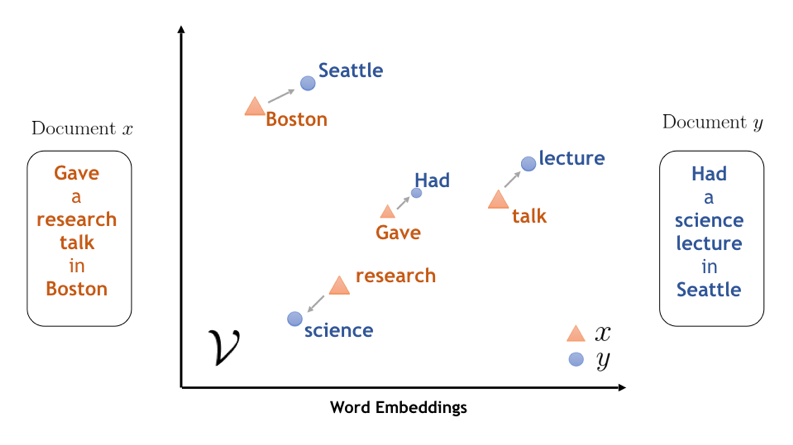
https://twitter.com/imVParashar/status/1425463062979436544/photo/1

Visualizations are necessarily in 2 or 3 dimensions to help us imagine the vectors, but embeddings for practical use typically have hundreds of dimensions, the better to keep all the different kinds of meaning straight.

For example, one direction in this high dimensional space might be positive vs negative, which would really help with our sentiment analysis.  Another 2 dimensions could capture geography, so France is seen as closer to Germany than Korea.  Another direction could capture time, so dinosaurs are seen as farther from us than swords, but swords are close to shields.

Nobody actually designs these embeddings, though.  They're always created by some automatic process that gradually shoves similar items closer together.  So the features that result are not necessarily easily interpreted.

Importantly, the most meaningful directions in the high-dimensional embedding space may not be axis-aligned; positive sentiment versus negative sentiment might be there, but head off at an angle that isn't captured directly by one of the vector components.  So decision trees aren't necessarily going to be able to make elegant rules with these features.

For our embeddings, we'll use word2vec, a tool invented at Google about 10 years ago.  How word2vec's embeddings were created is beyond the scope of this course - we just want you to be able to use this tool.  (The short version is that a neural network is trained to do a task of predicting words in text, and in learning the task, it builds an internal representation of what words are similar that we can then extract and use for embeddings in other settings.)


In [ ]:
# Download a word2vec dictionary from words to vectors
# (slow, since it's about 1.7 GB)
# Dataset was 100 billion words; 3 million word vocabulary;
# 300-dimensional vectors
# more possible pretrained models at: https://radimrehurek.com/gensim/models/word2vec.html
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[=-------------------------------------------------] 3.4% 56.3/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
# What we downloaded is fundamentally a lookup table from words to vectors...
wv['king']

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [ ]:
# Said vectors don't mean much by themselves, except words similar in meaning
# are close in the space.
print(wv.most_similar('king')) # Prints words and cosines of angles with 'king' #cosine bc want adj/hyp --> angle between the two vectors

[('kings', 0.7138045430183411), ('queen', 0.6510956883430481), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204220056533813), ('prince', 0.6159993410110474), ('sultan', 0.5864824056625366), ('ruler', 0.5797567367553711), ('princes', 0.5646552443504333), ('Prince_Paras', 0.5432944297790527), ('throne', 0.5422105193138123)]


The measure of similarity of two words in the space is the cosine of the angle between the words' vectors, which could range from -1 (vectors point opposite directions) to 1 (vectors point same direction).  You don't need to worry about the exact mathematical operations that follow if you haven't taken DS120 or a similar math class.

In [ ]:
import numpy as np

# Example of unrelated word angle cosine
def find_cosine(vec1, vec2):
  # Scale vectors to both have unit length
  unit_vec1 = vec1/np.linalg.norm(vec1)
  unit_vec2 = vec2/np.linalg.norm(vec2)
  # The dot product of unit vectors gives the cosine of their angle
  return np.dot(unit_vec1,unit_vec2)

print(find_cosine(wv['king'], wv['faucet']))

NameError: name 'wv' is not defined

In [ ]:
# "Similarity" method just does the above for us
# (very slightly different, maybe because of order of operations?)
wv.similarity('king', 'faucet') #if 0 --> totally unrelated concepts

-0.011353324

A slight problem arises in trying to use these embeddings to classify a whole sentence:  sentences can have varying numbers of words, but we typically don't want a variable number of features for our ML.

We can just average the word vectors to get an average meaning vector for the sentence, and that will always have the same number of features (the size of the embedding).  But there are other more complicated ways of trying to get a sentence-level vector, too.

In [ ]:
# Turn a sentence into a vector by averaging the vectors of its words.
def find_avg_vector(txt, embedding):
  words = word_tokenize(txt)
  vec_sum = None
  count = 0
  for word in words:
    if word in embedding:
      count += 1
      if vec_sum is not None:
        vec_sum += embedding[word]
      else:
        # The embeddings are read-only unless you copy them
        vec_sum = embedding[word].copy()
  if vec_sum is None:
    return pd.Series(np.zeros((300,)))  # Treat no word found in embedding as zero vector
  return pd.Series(vec_sum/count)

find_avg_vector('Long live the king and queen!', wv)


0      0.008350
1      0.006836
2     -0.044714
3      0.106689
4      0.020312
         ...   
295   -0.146497
296   -0.050464
297   -0.093018
298    0.070752
299    0.033496
Length: 300, dtype: float32

The next bit augments the original dataframe with our new features for each sentence.  The first line applies our *find_avg_vector* function to each text snippet in the data, creating a new dataframe with average embeddings as rows.  The next line just renames the column headers.  And the final line glues these embeddings to the right of the original dataframe.

In [ ]:
# Now we can augment our original dataframe with these features
df_embeddings = df[0].apply(lambda txt: find_avg_vector(txt, wv))
# Avoid name confusion with existing columns
df_embeddings.rename(columns=lambda x: 'feature'+str(x), inplace=True)
df_augmented = pd.concat([df, df_embeddings], axis=1)

In [ ]:
df_augmented

,0,1,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299
0,"a stirring , funny and finally transporting re...",1,0.109483,0.110585,0.039462,0.106468,-0.021285,0.025146,-0.028510,-0.037853,...,-0.138738,0.009621,-0.105991,0.093079,-0.051120,-0.034385,0.027710,-0.068509,0.005526,-0.000739
1,apparently reassembled from the cutting room f...,0,-0.021259,0.061951,-0.032360,0.053778,-0.055842,-0.016391,0.033225,-0.067322,...,-0.184748,-0.021606,-0.036172,-0.012176,0.009610,-0.076322,0.026545,-0.001028,0.009727,-0.031389
2,they presume their audience wo n't sit still f...,0,0.068062,0.041575,0.003786,0.119223,-0.069238,-0.019818,0.051632,-0.060720,...,-0.111014,0.014683,-0.071850,0.026909,-0.034877,-0.050392,0.061415,-0.043189,0.051827,0.031394
3,this is a visually stunning rumination on love...,1,0.102990,0.020839,0.029064,0.101523,-0.032091,0.002337,0.079847,-0.144348,...,-0.139747,-0.008881,-0.033949,0.014701,-0.036909,-0.066066,0.028019,-0.079651,0.031368,0.006058
4,jonathan parker 's bartleby should have been t...,1,-0.027132,-0.017302,-0.015588,0.131014,-0.037980,-0.058454,-0.004726,-0.104289,...,-0.130965,0.035400,-0.020211,0.055566,-0.005648,-0.011530,0.005501,-0.090605,-0.013626,-0.022762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6915,"painful , horrifying and oppressively tragic ,...",1,0.022537,-0.000272,0.057593,0.102881,-0.039270,0.045752,0.133661,-0.030377,...,-0.084888,-0.029025,-0.005060,0.111853,-0.073843,0.021472,-0.050061,-0.081540,0.091028,-0.007861
6916,take care is nicely performed by a quintet of ...,0,-0.013876,0.070948,0.019079,0.069923,-0.012016,-0.033480,0.053188,-0.076874,...,-0.025117,0.007458,-0.155418,0.049202,-0.029500,0.048676,0.013401,-0.007595,0.029244,-0.036942
6917,"the script covers huge , heavy topics in a bla...",0,0.056892,0.057912,0.016284,0.087982,-0.060885,-0.020688,0.069796,-0.060552,...,-0.078557,0.018069,-0.041377,0.031525,-0.044858,0.020886,0.023314,-0.039000,0.014368,0.001907
6918,a seriously bad film with seriously warped log...,0,-0.023317,-0.001771,0.014974,0.104085,-0.072465,0.090320,0.103117,-0.009880,...,-0.119198,0.075995,-0.074166,0.011387,-0.093264,-0.020402,-0.004720,-0.031523,-0.038281,0.005973


Now we've again turned the natural language problem into a machine learning problem we know how to solve:  we've got numerical features and some labels, and we can just throw these into an arbitrary learning algorithm in scikit-learn.

The features won't be as interpretable, but we expect better performance because the system can leverage all the word similarity knowledge in word2vec's embeddings.

In [ ]:
# Home stretch.  Train/test split and train an arbitrary classifier.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

labels = df_augmented[1]
features = df_augmented.iloc[:,2:]
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7907514450867053

Was that good?  Well, it was over 6% better accuracy than with one-hot encoding!  More advanced neural network architectures can get all the way to 96.8% accuracy on this task, but they're beyond the scope of this course.  They still use the idea of embeddings.

In this lecture, we saw a basic way we could use natural language with machine learning - one-hot encoding - and a versatile way to improve the results when trying to treat words as vectors, which is using pre-trained word embeddings.  We also discussed a few other useful NLP techniques along the way, like tokenization, standardization with lowercasing, and lemmatization.  This is a deep field with complex models necessary for state-of-the-art performance, but pretrained embeddings can help you get respectable performance right out of the gate.